## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language models (for decoder and encoder)

* or just fine-tuning BART/ELECTRA/... ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# %pip install subword-nmt
# %pip install nltk
# %pip install torchtext

In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os

path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    path_do_data = './data.txt'
    if not os.path.exists(path_do_data):
        print("Dataset not found locally. Downloading from github.")
        !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc

Baseline solution BLEU score is quite low. Try to achieve at least __21__ BLEU on the test set. 
The checkpoints are:

* __21__ - minimal score to submit the homework, 30% of points

* __25__ - good score, 70% of points

* __27__ - excellent score, 100% of points

### Warning! The code below is deeeeeeeply deprecated and is provided only as simple guide.
We suggest you to stick to most recent pipelines here, e.g. by Huggingface: 
* Example notebook: [link](https://github.com/huggingface/notebooks/blob/main/examples/translation.ipynb)
* Converting your own dataset to specific format: [link](https://discuss.huggingface.co/t/correct-way-to-create-a-dataset-from-a-csv-file/15686/15)

In [3]:
# old deprecated code
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import torchtext
from torchtext.data import Field, BucketIterator

import math
import time

import matplotlib

matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer

In [52]:
results = {
    "seq2seq": {
        "bleu": 0,
        "n_params": 0,
        "train_time": 0
    },
    "attention": {
        "bleu": 0,
        "n_params": 0,
        "train_time": 0
    },
    "transformer": {
        "bleu": 0,
        "n_params": 0,
        "train_time": 0
    }
}

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [5]:
tokenizer_W = WordPunctTokenizer()


def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [6]:
SRC = Field(tokenize=tokenize,
            init_token='<sos>',
            eos_token='<eos>',
            lower=True)

TRG = Field(tokenize=tokenize,
            init_token='<sos>',
            eos_token='<eos>',
            lower=True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [7]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [8]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [9]:
SRC.build_vocab(train_data, min_freq=3)
TRG.build_vocab(train_data, min_freq=3)

In [10]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9262
Unique tokens in target (en) vocabulary: 6727


Here are tokens from original (RU) corpus:

In [11]:
SRC.vocab.itos[::1000]

['<unk>',
 'конференций',
 'фермерского',
 'компьютерами',
 'hacienda',
 'domus',
 'rathaus',
 'цветы',
 'ежедневных',
 'татр']

And from target (EN) corpus:

In [12]:
TRG.vocab.itos[::1000]

['<unk>', 'tranquil', 'dance', 'converted', 'nerja', 'shangri', 'mahdia']

And here is example from train dataset:

In [13]:
print(vars(train_data.examples[9]))

{'trg': ['popular', 'meals', 'from', 'the', 'hungarian', 'cuisine', 'can', 'be', 'tasted', 'at', 'the', 'restaurant', '.'], 'src': ['популярные', 'блюда', 'венгерской', 'кухни', 'можно', 'отведать', 'в', 'ресторане', '.']}


Let's check the length distributions:

Length distribution in Train data


(array([4.9100e+02, 8.6200e+03, 1.1094e+04, 8.8280e+03, 5.5640e+03,
        2.8280e+03, 1.4120e+03, 6.9200e+02, 2.6100e+02, 1.0000e+02,
        6.7000e+01, 2.5000e+01, 9.0000e+00, 4.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 1. ,  5.9, 10.8, 15.7, 20.6, 25.5, 30.4, 35.3, 40.2, 45.1, 50. ,
        54.9, 59.8, 64.7, 69.6, 74.5, 79.4, 84.3, 89.2, 94.1, 99. ]),
 <a list of 20 Patch objects>)

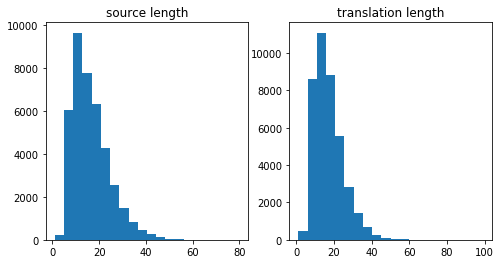

In [14]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20)

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20)

Length distribution in Test data


(array([4.730e+02, 1.239e+03, 1.733e+03, 1.099e+03, 1.163e+03, 6.080e+02,
        5.500e+02, 2.370e+02, 1.890e+02, 7.800e+01, 4.700e+01, 3.400e+01,
        2.100e+01, 1.200e+01, 7.000e+00, 5.000e+00, 2.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 4.  ,  7.45, 10.9 , 14.35, 17.8 , 21.25, 24.7 , 28.15, 31.6 ,
        35.05, 38.5 , 41.95, 45.4 , 48.85, 52.3 , 55.75, 59.2 , 62.65,
        66.1 , 69.55, 73.  ]),
 <a list of 20 Patch objects>)

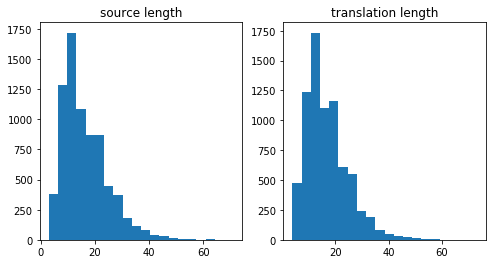

In [15]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20)

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20)

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
device

device(type='cuda')

In [18]:
def _len_sort_key(x):
    return len(x.src)


BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    device=device,
    sort_key=_len_sort_key
)

In [19]:
for x in train_iterator:
    print(x)
    print(x.src.shape, x.trg.shape)
    break


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 57x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 43x128 (GPU 0)]
torch.Size([43, 128]) torch.Size([57, 128])


In [20]:
import my_network

Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [21]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = Seq2Seq(enc, dec, device).to(device)

In [22]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)


model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9262, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6727, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6727, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [25]:
def count_parameters(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

results["seq2seq"]["n_params"] = count_parameters(model)
print(f'The model has {results["seq2seq"]["n_params"]:,} trainable parameters')

The model has 14,900,551 trainable parameters


In [26]:
PAD_IDX = TRG.vocab.stoi['<pad>']
SOS_IDX = TRG.vocab.stoi['<sos>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
lr_scheduler = StepLR(optimizer=optimizer, step_size=3, gamma=0.5)

In [27]:
def train(m, iterator, opt, crit, clip, train_history=None, valid_history=None):
    m.train()

    epoch_loss = 0
    history = []
    for i, b in enumerate(iterator):
        source = b.src
        target = b.trg

        opt.zero_grad()

        output = m(source, target)

        # target = [target sent len, batch size]
        # output = [target sent len, batch size, output dim]

        output = output[1:].view(-1, output.shape[-1])
        target = target[1:].view(-1)

        # target = [(target sent len - 1) * batch size]
        # output = [(target sent len - 1) * batch size, output dim]

        loss = crit(output, target)

        loss.backward()

        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(m.parameters(), clip)

        opt.step()

        epoch_loss += loss.item()

        history.append(loss.cpu().data.numpy())
        if (i + 1) % 10 == 0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()

            plt.show()

    return epoch_loss / len(iterator)

In [28]:
def evaluate(m, iterator, crit):
    m.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, b in enumerate(iterator):
            source = b.src
            target = b.trg

            output = m(source, target, 0)  #turn off teacher forcing

            # target = [target sent len, batch size]
            # output = [target sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            target = target[1:].view(-1)

            # target = [(target sent len - 1) * batch size]
            # output = [(target sent len - 1) * batch size, output dim]

            loss = crit(output, target)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [29]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [30]:
def train_model(m,
                train_iter,
                valid_iter,
                opt,
                crit,
                lr_sch,
                n_epochs=10,
                clip=1,
                model_name='model'):
    train_history = []
    valid_history = []

    best_valid_loss = float('inf')

    main_start = time.time()

    for epoch in range(n_epochs):
        start_time = time.time()

        train_loss = train(m, train_iter, opt, crit, clip, train_history, valid_history)
        valid_loss = evaluate(m, valid_iter, crit)

        lr_sch.step(valid_loss)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(m.state_dict(), f"{model_name}.pth")

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    main_end = time.time()
    results[model_name]["train_time"] = main_end - main_start

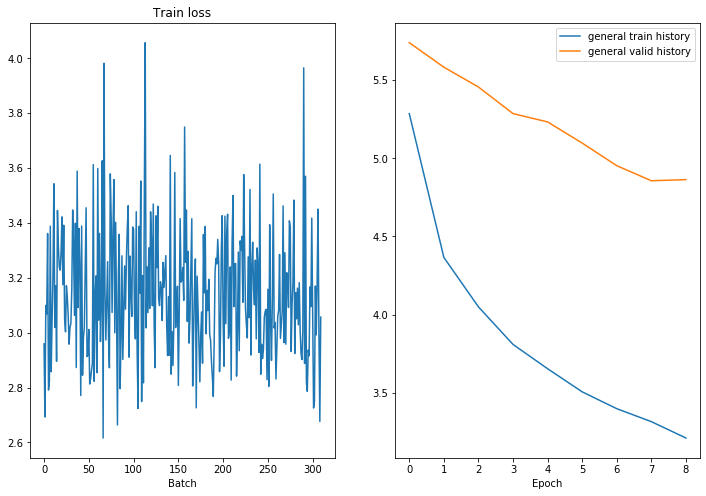

/home/jupyter/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 10 | Time: 1m 2s
	Train Loss: 3.139 | Train PPL:  23.071
	 Val. Loss: 4.805 |  Val. PPL: 122.163


In [31]:
train_model(model,
            train_iterator,
            valid_iterator,
            optimizer,
            criterion,
            lr_scheduler,
            model_name="seq2seq")

__Let's take a look at our network quality__:

In [38]:
import utils
import importlib

importlib.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [39]:
batch = next(iter(test_iterator))

In [40]:
for idx in [1, 2]:
    src = batch.src[:, idx:idx + 1]
    trg = batch.trg[:, idx:idx + 1]
    generate_translation(src, trg, model, TRG.vocab)

Original: parking is free .
Generated: free private parking .

Original: guests can enjoy the on - site bar .
Generated: divnomorskoye include a private .



In [41]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [42]:
import tqdm

In [43]:
def generate_texts(m, test_iter):
    original_text = []
    generated_text = []
    m.eval()
    with torch.no_grad():
        for i, b in tqdm.tqdm(enumerate(test_iter)):
            source = b.src
            target = b.trg

            output = m(source, target, 0)  # turn off teacher forcing

            # target = [target sent len, batch size]
            # output = [target sent len, batch size, output dim]

            output = output.argmax(dim=-1)

            original_text.extend([get_text(x, TRG.vocab) for x in target.cpu().numpy().T])
            generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

    return original_text, generated_text

In [44]:
original_text_Seq2Seq, generated_text_Seq2Seq = generate_texts(model, test_iterator)

59it [00:03, 19.60it/s]


In [45]:
results["seq2seq"]["bleu"] = corpus_bleu([[text] for text in original_text_Seq2Seq], generated_text_Seq2Seq) * 100
results["seq2seq"]["bleu"]

12.713383845180276

### Attention

In [46]:
Encoder = my_network.Encoder
DecoderAttention = my_network.DecoderAttention
Seq2SeqAttention = my_network.Seq2SeqAttention

In [47]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec_attention = DecoderAttention(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model_attention = Seq2SeqAttention(enc, dec_attention, device).to(device)

In [48]:
model_attention.apply(init_weights)

Seq2SeqAttention(
  (encoder): Encoder(
    (embedding): Embedding(9262, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): DecoderAttention(
    (embedding): Embedding(6727, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (attention): Attention(
      (linear_in): Linear(in_features=512, out_features=512, bias=False)
      (linear_out): Linear(in_features=1024, out_features=512, bias=False)
      (softmax): Softmax(dim=-1)
      (tanh): Tanh()
    )
    (out): Linear(in_features=512, out_features=6727, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [54]:
results["attention"]["n_params"] = count_parameters(model_attention)
print(f'The model has {results["attention"]["n_params"]:,} trainable parameters')

The model has 15,686,983 trainable parameters


In [55]:
optimizer_attention = optim.AdamW(model_attention.parameters())
criterion_attention = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
lr_scheduler_attention = ReduceLROnPlateau(optimizer=optimizer_attention, patience=2, factor=0.2)

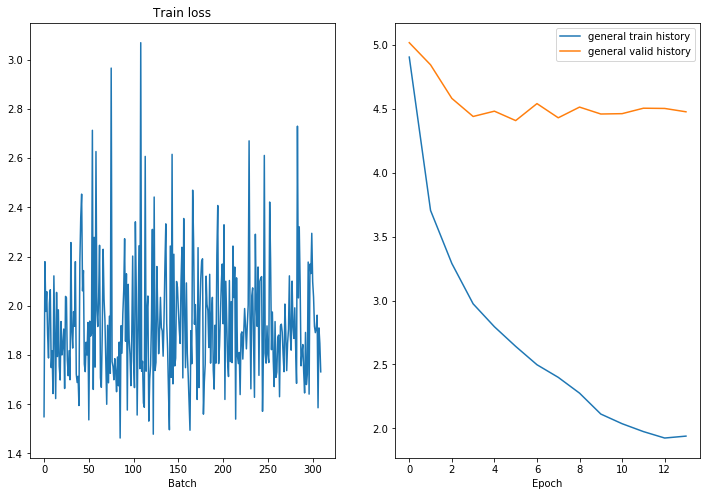

Epoch: 15 | Time: 1m 16s
	Train Loss: 1.928 | Train PPL:   6.874
	 Val. Loss: 4.491 |  Val. PPL:  89.202


In [56]:
train_model(model_attention,
            train_iterator,
            valid_iterator,
            optimizer_attention,
            criterion_attention,
            lr_scheduler_attention,
            n_epochs=15,
            model_name="attention")

In [57]:
original_text_attention, generated_text_attention = generate_texts(model_attention, test_iterator)

59it [00:03, 15.94it/s]


In [58]:
results["attention"]["bleu"] = corpus_bleu([[text] for text in original_text_attention], generated_text_attention) * 100
results["attention"]["bleu"]

31.240721148226402

In [59]:
for idx in [1, 2, 3, 4, 5]:
    src = batch.src[:, idx:idx + 1]
    trg = batch.trg[:, idx:idx + 1]
    generate_translation(src, trg, model_attention, TRG.vocab)

Original: parking is free .
Generated: the property offers free parking .

Original: guests can enjoy the on - site bar .
Generated: guests can enjoy the on - site bar .

Original: a hairdryer is provided upon request .
Generated: hairdryers are available upon request .

Original: free wifi is available .
Generated: free wi - fi access is available .

Original: some rooms have a balcony .
Generated: some rooms have a balcony .



### Transformer

In [60]:
Seq2SeqTransformer = my_network.Seq2SeqTransformer

In [61]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
NHEAD = 2
ENC_LAYERS = 2
DEC_LAYERS = 2
EMB_DIM = 512
DROPOUT = 0.2

model_transformer = Seq2SeqTransformer(INPUT_DIM, OUTPUT_DIM, EMB_DIM,
                                       NHEAD, ENC_LAYERS, DEC_LAYERS).to(device)

In [62]:
optimizer_transformer = optim.AdamW(model_transformer.parameters())
criterion_transformer = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
lr_scheduler_transformer = ReduceLROnPlateau(optimizer=optimizer_transformer, patience=2, factor=0.2)

In [63]:
results["transformer"]["n_params"] = count_parameters(model_transformer)
print(f'The model has {results["transformer"]["n_params"]:,} trainable parameters')

The model has 26,352,200 trainable parameters


In [64]:
def init_weights_transformer(m):
    for p in m.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

In [65]:
model_transformer.apply(init_weights_transformer)

Seq2SeqTransformer(
  (enc_emb): Embedding(9262, 512)
  (dec_emb): Embedding(6727, 512)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_model): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_af

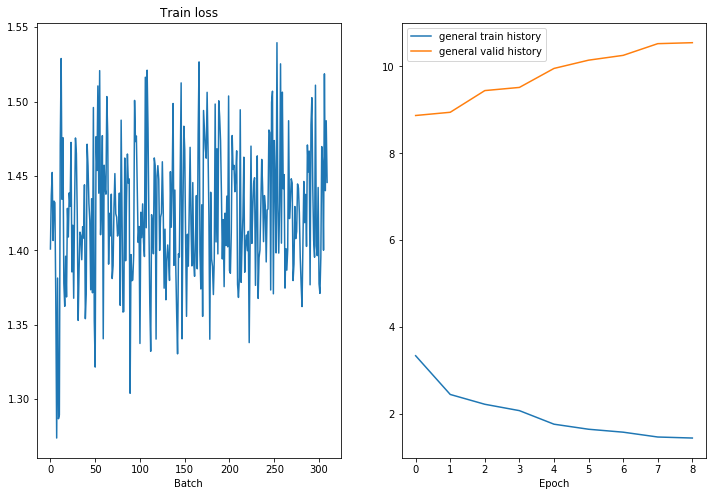

Epoch: 10 | Time: 0m 40s
	Train Loss: 1.423 | Train PPL:   4.150
	 Val. Loss: 10.667 |  Val. PPL: 42927.511


In [66]:
train_model(model_transformer,
            train_iterator,
            valid_iterator,
            optimizer_transformer,
            criterion_transformer,
            lr_scheduler_transformer,
            model_name="transformer")

In [67]:
original_text_transformer, generated_text_transformer = generate_texts(model_transformer, test_iterator)

59it [00:11,  5.07it/s]


In [68]:
results["transformer"]["bleu"] = corpus_bleu([[text] for text in original_text_transformer], generated_text_transformer) * 100
results["transformer"]["bleu"]

13.163978374992732

In [69]:
for idx in [1, 2, 3, 4, 5]:
    src = batch.src[:, idx:idx + 1]
    trg = batch.trg[:, idx:idx + 1]
    generate_translation(src, trg, model_transformer, TRG.vocab)

Original: parking is free .
Generated: property offers free parking .

Original: guests can enjoy the on - site bar .
Generated: is also a bar on site .

Original: a hairdryer is provided upon request .
Generated: service is available .

Original: free wifi is available .
Generated: wifi access is available .

Original: some rooms have a balcony .
Generated: rooms have a balcony .



### Conclusion

In [70]:
import pandas as pd
display(pd.DataFrame(results).loc[["bleu", "train_time", "n_params"]])

,seq2seq,attention,transformer
bleu,1.271338e+01,3.124072e+01,1.316398e+01
train_time,6.426948e+02,1.156563e+03,4.130778e+02
n_params,1.490055e+07,1.568698e+07,2.635220e+07


The best result were shown by the Seq2Seq model with attention. Introducing a learning rate scheduler (the first model) or a transformer (the third model) produce much worse results. The transformer network seems to be overfitting (by the looks of the loss graph). It could be a separate lab to try and find a solution for that.